In [1]:

import xgboost as xgb
import optuna
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from etrace.load_data import load_from_bq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

/Users/jaumerayo/.pyenv/versions/3.12.9/envs/etrace_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
df = load_from_bq("SELECT * FROM aklewagonproject.etrace.cleaned_final_jaume_dataset")

In [26]:
df.columns

Index(['geo', 'year', 'pop', 'employment_rate', 'gdp_capita', 'NUTS_NAME',
       'area_km2', 'pop_dens', 'pct_Dfb', 'pct_Dfc', 'pct_ET', 'pct_EF',
       'pct_Cfb', 'pct_BSk', 'pct_Csa', 'pct_Csb', 'pct_Cfa', 'pct_Dfa',
       'pct_Dsb', 'pct_Dsc', 'pct_BSh', 'pct_BWk', 'pct_Cfc', 'pct_BWh',
       'pct_Af', 'pct_Am', 'pct_Aw', 'pct_Cwa', 'pct_Cwb', 'pct_Csc',
       'pct_Dsa', 'tx', 'tg', 'tn', 'rr', 'hu', 'fg', 'qq',
       'NUTS_NAME_completo', 'CNTR_CODE', 'is_coastal', 'nights_spent'],
      dtype='object')

In [31]:
df = df.drop(columns=['tx', 'tg', 'tn', 'rr', 'hu', 'fg', 'qq',
       'NUTS_NAME_completo', 'CNTR_CODE'])

In [32]:
df.head()

,geo,year,pop,employment_rate,gdp_capita,NUTS_NAME,area_km2,pop_dens,pct_Dfb,pct_Dfc,...,pct_BWh,pct_Af,pct_Am,pct_Aw,pct_Cwa,pct_Cwb,pct_Csc,pct_Dsa,is_coastal,nights_spent
0,CY00,2000,690497.0,72.0,15600.0,Κύπρος,9258.638861,74.578673,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,17419055.0
1,CY00,2001,697549.0,74.1,16500.0,Κύπρος,9258.638861,75.340340,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,18826208.0
2,CY00,2002,705539.0,75.1,17000.0,Κύπρος,9258.638861,76.203318,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,16159347.0
3,CY00,2003,713720.0,75.4,17900.0,Κύπρος,9258.638861,77.086925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,14457937.0
4,CY00,2004,722893.0,75.7,19100.0,Κύπρος,9258.638861,78.077675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,14717269.0


## Some of the NUTS-2 IDs are missing a lot of years to solve this we will apply a filter, first of all lets see which are this IDs

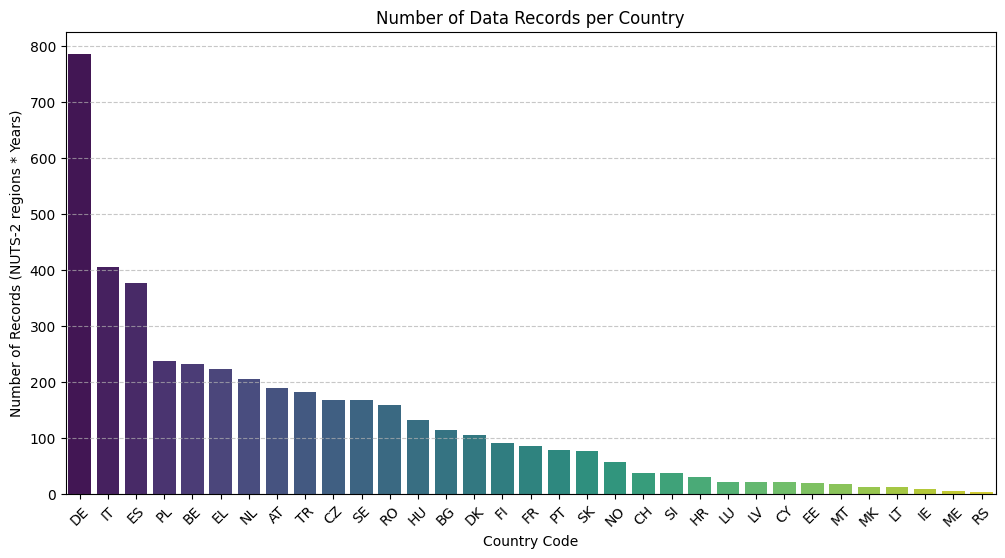

In [33]:
# Extract Country Code from the 'geo' column (NUTS-2 IDs)
df['country'] = df['geo'].str[:2]

country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'record_count']

# Uncomment the follow two lines if you want to see a table with lowest country records
# print("Countries with the fewest records:")
# print(country_counts.sort_values('record_count').head(10))

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=country_counts, x='country', y='record_count', hue='country', palette='viridis', legend=False)
plt.title('Number of Data Records per Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Records (NUTS-2 regions * Years)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [34]:
# List of countries to exclude based on low record count analysis
countries_to_drop = ['RS', 'ME', 'IE', 'LT', 'MK', 'MT', 'EE', 'LU', 'LV', 'CY']

# Filter the DataFrame
df_clean = df[~df['country'].isin(countries_to_drop)].copy()

df_clean = df_clean.drop(columns=['NUTS_NAME','employment_rate','country'])

print(f"Original shape: {df.shape}")
print(f"Shape after dropping low-data countries: {df_clean.shape}")

Original shape: (4317, 34)
Shape after dropping low-data countries: (4175, 31)


In [35]:
df_clean.head()

,geo,year,pop,gdp_capita,area_km2,pop_dens,pct_Dfb,pct_Dfc,pct_ET,pct_EF,...,pct_BWh,pct_Af,pct_Am,pct_Aw,pct_Cwa,pct_Cwb,pct_Csc,pct_Dsa,is_coastal,nights_spent
80,TR21,2013,1593247.0,10600.0,18793.144498,84.778096,0.000143,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,435859.0
81,TR21,2014,1613616.0,10500.0,18793.144498,85.861948,0.000157,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,545903.0
82,TR21,2015,1650735.0,11300.0,18793.144498,87.837083,0.000170,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,588416.0
83,TR21,2016,1687420.0,11400.0,18793.144498,89.789125,0.000181,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,586368.0
84,TR32,2013,2808243.0,8200.0,32506.717238,86.389622,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,17870115.0


In [36]:
cols_to_exclude = ["nights_spent", "geo", "year"]

X = df_clean.drop(
    columns=[c for c in cols_to_exclude if c in df_clean.columns], errors="ignore"
)
y = df_clean["nights_spent"]

N_FOLDS = 5

cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_predictions = np.zeros(len(X)) #Out of fold
fold_scores = []

# Model parameters
model_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "learning_rate": 0.1,
    "max_depth": 11,
    "min_child_weight": 16,
    "subsample": 0.77,
    "colsample_bytree": 0.96,
    "lambda": 0.07,
    "alpha": 8.48,
    "random_state": 42,
    "verbosity": 0,
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    # Split data
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    #We need DMatrix because XGB doesnt work with pd dataframes :(
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

    model = xgb.train(
        params=model_params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=[(dval, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,
    )

    fold_predictions = model.predict(dval)
    oof_predictions[val_idx] = fold_predictions

    # Calculate fold metrics
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, fold_predictions))
    fold_r2 = r2_score(y_val_fold, fold_predictions)
    fold_scores.append({"fold": fold + 1, "rmse": fold_rmse, "r2": fold_r2})


overall_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
overall_r2 = r2_score(y, oof_predictions)


fold_rmses = [score["rmse"] for score in fold_scores]
rmse_mean = np.mean(fold_rmses)
rmse_std = np.std(fold_rmses)

imputer = SimpleImputer(strategy='median')

# Fill NaNs
X[["pop", "gdp_capita"]] = imputer.fit_transform(X[["pop", "gdp_capita"]])

meta_features = np.column_stack([oof_predictions, X[["pop", "gdp_capita"]].values])

meta_oof_predictions = np.zeros(len(X))
meta_cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=43)

for fold, (train_idx, val_idx) in enumerate(meta_cv.split(X)):
    X_meta_train = meta_features[train_idx]
    X_meta_val = meta_features[val_idx]
    y_meta_train = y.iloc[train_idx]
    y_meta_val = y.iloc[val_idx]

    meta_model = Ridge(alpha=1.0, random_state=42)
    meta_model.fit(X_meta_train, y_meta_train)

    meta_fold_predictions = meta_model.predict(X_meta_val)
    meta_oof_predictions[val_idx] = meta_fold_predictions


meta_rmse = np.sqrt(mean_squared_error(y, meta_oof_predictions))
meta_r2 = r2_score(y, meta_oof_predictions)

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dtrain_simple = xgb.DMatrix(X_train_simple, label=y_train_simple)
dtest_simple = xgb.DMatrix(X_test_simple, label=y_test_simple)

simple_model = xgb.train(
    params=model_params,
    dtrain=dtrain_simple,
    num_boost_round=200,
    evals=[(dtest_simple, "test")],
    early_stopping_rounds=20,
    verbose_eval=False,
)

simple_predictions = simple_model.predict(dtest_simple)
simple_rmse = np.sqrt(mean_squared_error(y_test_simple, simple_predictions))
simple_r2 = r2_score(y_test_simple, simple_predictions)

improvement = ((overall_rmse - meta_rmse) / overall_rmse) * 100


results_df = pd.DataFrame(
    {
        "actual": y,
        "oof_predictions": oof_predictions,
        "meta_predictions": meta_oof_predictions,
        "oof_residuals": y - oof_predictions,
        "meta_residuals": y - meta_oof_predictions,
    }
)

results_df.to_csv("simple_oof_stacking_results.csv", index=False)

In [37]:
# XGBOOST METRICS (Cross-Validation)
print("\n XGBOOST WITH CROSS-VALIDATION:")
print(f"   Overall RMSE: {overall_rmse:.2f}")
print(f"   Overall R²: {overall_r2:.4f}")
print(f"   Average RMSE per fold: {rmse_mean:.2f} ± {rmse_std:.2f}")

# FOLD DETAILS
print("\nFOLD BREAKDOWN:")
for score in fold_scores:
    print(f"   Fold {score['fold']}: RMSE={score['rmse']:.2f}, R²={score['r2']:.4f}")

# META-MODEL METRICS
print("\nMETA-MODEL (STACKING):")
print(f"   Meta RMSE: {meta_rmse:.2f}")
print(f"   Meta R²: {meta_r2:.4f}")

# SIMPLE MODEL METRICS
print("\n SIMPLE MODEL (Train/Test Split):")
print(f"   Simple RMSE: {simple_rmse:.2f}")
print(f"   Simple R²: {simple_r2:.4f}")


 XGBOOST WITH CROSS-VALIDATION:
   Overall RMSE: 3335767.55
   Overall R²: 0.9371
   Average RMSE per fold: 3303781.25 ± 460841.18

FOLD BREAKDOWN:
   Fold 1: RMSE=3156375.38, R²=0.9393
   Fold 2: RMSE=3313680.78, R²=0.9482
   Fold 3: RMSE=4176277.20, R²=0.8875
   Fold 4: RMSE=3002212.23, R²=0.9450
   Fold 5: RMSE=2870360.64, R²=0.9564

META-MODEL (STACKING):
   Meta RMSE: 3361088.40
   Meta R²: 0.9361

 SIMPLE MODEL (Train/Test Split):
   Simple RMSE: 3272432.39
   Simple R²: 0.9347


In [38]:
# OMPARISON
print("\n" + "="*70)
print("=== COMPARATIVE TABLE ===")
print("="*70)
print(f"{'Model':<35} {'RMSE':<12} {'R²':<10}")
print("-"*70)
print(f"{'XGBoost (Cross-Validation)':<35} {overall_rmse:<12.2f} {overall_r2:<10.4f}")
print(f"{'Meta-Model (Stacking)':<35} {meta_rmse:<12.2f} {meta_r2:<10.4f}")
print(f"{'XGBoost Simple (Train/Test)':<35} {simple_rmse:<12.2f} {simple_r2:<10.4f}")
print("="*70)

# IMPROVEMENT
if improvement > 0:
    print(f"\nSTACKING IMPROVEMENT: +{improvement:.2f}%")
    print(f"   Meta-model reduced error by {abs(overall_rmse - meta_rmse):.2f} nights")
else:
    print(f"\nSTACKING DETERIORATION: {improvement:.2f}%")
    print(f"   Meta-model increased error by {abs(overall_rmse - meta_rmse):.2f} nights")

# 7. CSV INFORMATION
print("\n FILE SAVED:")
print(f"simple_oof_stacking_results.csv")
print(f"{len(results_df)} rows × {len(results_df.columns)} columns")
print(f"   Columns: {', '.join(results_df.columns.tolist())}")

# 8. CSV PREVIEW
print("RESULTS PREVIEW (first 5 rows):")
print(results_df.head())



=== COMPARATIVE TABLE ===
Model                               RMSE         R²        
----------------------------------------------------------------------
XGBoost (Cross-Validation)          3335767.55   0.9371    
Meta-Model (Stacking)               3361088.40   0.9361    
XGBoost Simple (Train/Test)         3272432.39   0.9347    

STACKING DETERIORATION: -0.76%
   Meta-model increased error by 25320.86 nights

 FILE SAVED:
simple_oof_stacking_results.csv
4175 rows × 5 columns
   Columns: actual, oof_predictions, meta_predictions, oof_residuals, meta_residuals
RESULTS PREVIEW (first 5 rows):
        actual  oof_predictions  meta_predictions  oof_residuals  \
80    435859.0     2.171849e+06      2.133047e+06   -1735989.750   
81    545903.0     1.420615e+06      1.311593e+06    -874712.000   
82    588416.0     2.677963e+06      2.700959e+06   -2089546.750   
83    586368.0     1.010341e+06      1.021496e+06    -423972.875   
84  17870115.0     1.520550e+07      1.535449e+07    266

count    4.175000e+03
mean     9.255858e+06
std      1.330260e+07
min      4.834400e+04
25%      2.471279e+06
50%      5.149174e+06
75%      9.564070e+06
max      1.043826e+08
Name: nights_spent, dtype: float64


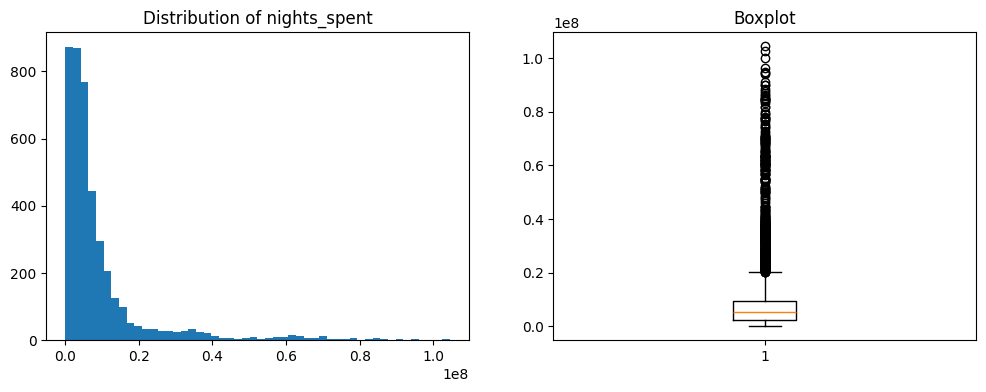

In [39]:
# Distribution of night spent
print(y.describe())

# outliers
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y, bins=50)
plt.title('Distribution of nights_spent')
plt.subplot(1,2,2)
plt.boxplot(y)
plt.title('Boxplot')
plt.show()

# Log transformation to night spent
Our target variable exhibits variance that scales with magnitude. Standard deviation (13.3M) exceeds the mean (9.2M), indicating severe heteroscedasticity. Machine learning models assume constant variance across the prediction range—this assumption is violated.

**Consequence:** Model optimization becomes unstable. Gradient-based algorithms receive inconsistent signals depending on the scale of values, leading to poor convergence and biased predictions toward high-magnitude observations.


In [40]:
cols_to_exclude = ["nights_spent", "geo", "year"]
X = df_clean.drop(
    columns=[c for c in cols_to_exclude if c in df_clean.columns], errors="ignore"
)
y = df_clean["nights_spent"]
y_log = np.log1p(y)

N_FOLDS = 5
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
oof_predictions_log = np.zeros(len(X))
oof_predictions = np.zeros(len(X))
fold_scores = []

model_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "learning_rate": 0.1,
    "max_depth": 11,
    "min_child_weight": 16,
    "subsample": 0.77,
    "colsample_bytree": 0.96,
    "lambda": 0.07,
    "alpha": 8.48,
    "random_state": 42,
    "verbosity": 0,
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y_log.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_log.iloc[val_idx])

    model = xgb.train(
        params=model_params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=[(dval, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,
    )

    fold_predictions_log = model.predict(dval)
    fold_predictions = np.expm1(fold_predictions_log)
    oof_predictions_log[val_idx] = fold_predictions_log
    oof_predictions[val_idx] = fold_predictions

    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, fold_predictions))
    fold_r2 = r2_score(y_val_fold, fold_predictions)
    fold_scores.append({"fold": fold + 1, "rmse": fold_rmse, "r2": fold_r2})

overall_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
overall_r2 = r2_score(y, oof_predictions)

overall_rmse_log = np.sqrt(mean_squared_error(y_log, oof_predictions_log))
overall_r2_log = r2_score(y_log, oof_predictions_log)

fold_rmses = [score["rmse"] for score in fold_scores]
rmse_mean = np.mean(fold_rmses)
rmse_std = np.std(fold_rmses)

imputer = SimpleImputer(strategy='median')
X[["pop", "gdp_capita"]] = imputer.fit_transform(X[["pop", "gdp_capita"]])

meta_features = np.column_stack([oof_predictions_log, X[["pop", "gdp_capita"]].values])
meta_oof_predictions_log = np.zeros(len(X))
meta_oof_predictions = np.zeros(len(X))
meta_cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=43)

for fold, (train_idx, val_idx) in enumerate(meta_cv.split(X)):
    X_meta_train = meta_features[train_idx]
    X_meta_val = meta_features[val_idx]
    y_meta_train = y_log.iloc[train_idx]
    y_meta_val = y_log.iloc[val_idx]

    meta_model = Ridge(alpha=1.0, random_state=42)
    meta_model.fit(X_meta_train, y_meta_train)

    meta_fold_predictions_log = meta_model.predict(X_meta_val)
    meta_fold_predictions = np.expm1(meta_fold_predictions_log)
    meta_oof_predictions_log[val_idx] = meta_fold_predictions_log
    meta_oof_predictions[val_idx] = meta_fold_predictions

meta_rmse = np.sqrt(mean_squared_error(y, meta_oof_predictions))
meta_r2 = r2_score(y, meta_oof_predictions)

meta_rmse_log = np.sqrt(mean_squared_error(y_log, meta_oof_predictions_log))
meta_r2_log = r2_score(y_log, meta_oof_predictions_log)

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
y_test_simple_original = y[y_test_simple.index]

dtrain_simple = xgb.DMatrix(X_train_simple, label=y_train_simple)
dtest_simple = xgb.DMatrix(X_test_simple, label=y_test_simple)

simple_model = xgb.train(
    params=model_params,
    dtrain=dtrain_simple,
    num_boost_round=200,
    evals=[(dtest_simple, "test")],
    early_stopping_rounds=20,
    verbose_eval=False,
)

simple_predictions_log = simple_model.predict(dtest_simple)
simple_predictions = np.expm1(simple_predictions_log)

simple_rmse = np.sqrt(mean_squared_error(y_test_simple_original, simple_predictions))
simple_r2 = r2_score(y_test_simple_original, simple_predictions)

improvement = ((overall_rmse - meta_rmse) / overall_rmse) * 100

results_df = pd.DataFrame(
    {
        "actual": y,
        "oof_predictions": oof_predictions,
        "meta_predictions": meta_oof_predictions,
        "oof_residuals": y - oof_predictions,
        "meta_residuals": y - meta_oof_predictions,
    }
)

results_df.to_csv("simple_oof_stacking_results_log.csv", index=False)

In [41]:
print("\nXGBOOST WITH CROSS-VALIDATION:")
print(f"   Overall RMSE: {overall_rmse:.2f}")
print(f"   Overall R²: {overall_r2:.4f}")
print(f"   Overall RMSE (log scale): {overall_rmse_log:.4f}")
print(f"   Overall R² (log scale): {overall_r2_log:.4f}")
print(f"   Average RMSE per fold: {rmse_mean:.2f} ± {rmse_std:.2f}")

print("\nFOLD BREAKDOWN:")
for score in fold_scores:
    print(f"   Fold {score['fold']}: RMSE={score['rmse']:.2f}, R²={score['r2']:.4f}")


print("\nMETA-MODEL (STACKING):")
print(f"   Meta RMSE: {meta_rmse:.2f}")
print(f"   Meta R²: {meta_r2:.4f}")
print(f"   Meta RMSE (log scale): {meta_rmse_log:.4f}")
print(f"   Meta R² (log scale): {meta_r2_log:.4f}")

print("\nSIMPLE MODEL (Train/Test Split):")
print(f"   Simple RMSE: {simple_rmse:.2f}")
print(f"   Simple R²: {simple_r2:.4f}")


print("\n" + "="*70)
print("=== COMPARATIVE TABLE ===")
print("="*70)
print(f"{'Model':<35} {'RMSE':<12} {'R²':<10}")
print("-"*70)
print(f"{'XGBoost (Cross-Validation)':<35} {overall_rmse:<12.2f} {overall_r2:<10.4f}")
print(f"{'Meta-Model (Stacking)':<35} {meta_rmse:<12.2f} {meta_r2:<10.4f}")
print(f"{'XGBoost Simple (Train/Test)':<35} {simple_rmse:<12.2f} {simple_r2:<10.4f}")
print("="*70)

if improvement > 0:
    print(f"\nTACKING IMPROVEMENT: +{improvement:.2f}%")
    print(f"   Meta-model reduced error by {abs(overall_rmse - meta_rmse):.2f} nights")
else:
    print(f"\nSTACKING DETERIORATION: {improvement:.2f}%")


XGBOOST WITH CROSS-VALIDATION:
   Overall RMSE: 4391897.00
   Overall R²: 0.8910
   Overall RMSE (log scale): 0.2991
   Overall R² (log scale): 0.9290
   Average RMSE per fold: 4346373.40 ± 630711.90

FOLD BREAKDOWN:
   Fold 1: RMSE=4089888.21, R²=0.8980
   Fold 2: RMSE=5499195.74, R²=0.8574
   Fold 3: RMSE=4222627.75, R²=0.8850
   Fold 4: RMSE=3585616.91, R²=0.9216
   Fold 5: RMSE=4334538.40, R²=0.9006

META-MODEL (STACKING):
   Meta RMSE: 4301954.33
   Meta R²: 0.8954
   Meta RMSE (log scale): 0.2958
   Meta R² (log scale): 0.9306

SIMPLE MODEL (Train/Test Split):
   Simple RMSE: 3893234.66
   Simple R²: 0.9076

=== COMPARATIVE TABLE ===
Model                               RMSE         R²        
----------------------------------------------------------------------
XGBoost (Cross-Validation)          4391897.00   0.8910    
Meta-Model (Stacking)               4301954.33   0.8954    
XGBoost Simple (Train/Test)         3893234.66   0.9076    

TACKING IMPROVEMENT: +2.05%
   Meta-mod

In [42]:
# Train XGBoost final
dtrain_final = xgb.DMatrix(X, label=y_log)
modelo_xgb_final = xgb.train(params=model_params, dtrain=dtrain_final, num_boost_round=200)

# train meta-modelo final
preds_log = modelo_xgb_final.predict(dtrain_final)
meta_feat = np.column_stack([preds_log, X[["pop", "gdp_capita"]].values])
modelo_meta_final = Ridge(alpha=1.0, random_state=42)
modelo_meta_final.fit(meta_feat, y_log)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


# Constructing Predict DF : 
### First, let's build a dataframe with the predicted economic variables for the 2041-2070 range. Using the last years of our dataframe and performing a linear regression, we obtain the coefficients to extrapolate these variables

In [44]:
query = "SELECT * FROM aklewagonproject.etrace.cleaned_final_jaume_dataset"

In [45]:
df = load_from_bq(query)
df["country"] = df["geo"].str[:2]
country_counts = df["country"].value_counts().reset_index()
country_counts.columns = ["country", "record_count"]
countries_to_drop = ["RS", "ME", "IE", "LT", "MK", "MT", "EE", "LU", "LV", "CY"]
df_clean = df[~df["country"].isin(countries_to_drop)].copy()

df_clean = df_clean.drop(columns=["NUTS_NAME"])

regions = df_clean.geo.unique()
region_dict = {}
last_values = {}
features = [
    "pop",
    "employment_rate",
    "gdp_capita",
    "pop_dens",
]

for region in regions:
    for feature in features:
        feature_hist_data = df_clean.loc[df_clean.geo == region, feature].dropna()

        if len(feature_hist_data) < 2:
            continue

        yearly_change = feature_hist_data.diff().mean()
        last_value = feature_hist_data.iloc[-1]

        if pd.isna(yearly_change):
            yearly_change = 0.0
        if pd.isna(last_value):
            continue

        region_dict.update({f"{region}_{feature}": float(yearly_change)})
        last_values.update({f"{region}_{feature}": float(last_value)})

all_inrerpolated = []
for region in regions:
    current_values = {}
    has_all_features = True
    for feature in features:
        feature_key = f"{region}_{feature}"
        if feature_key not in last_values or feature_key not in region_dict:
            has_all_features = False
            break
        current_values[feature] = last_values[feature_key]

    if not has_all_features:
        continue

    for year in range(2020, 2071):
        row = {"region": region, "year": year}

        for feature in features:
            yearly_change = region_dict[f"{region}_{feature}"]
            current_values[feature] += yearly_change
            row[feature] = current_values[feature]

            # here i have final which = one, two,

        all_inrerpolated.append(row)

inter = pd.DataFrame(all_inrerpolated)
inter.head()

,region,year,pop,employment_rate,gdp_capita,pop_dens
0,TR21,2020,1.870802e+06,60.966667,8966.666667,99.547027
1,TR21,2021,1.910452e+06,61.233333,8733.333333,101.656875
2,TR21,2022,1.950103e+06,61.500000,8500.000000,103.766722
3,TR21,2023,1.989754e+06,61.766667,8266.666667,105.876569
4,TR21,2024,2.029404e+06,62.033333,8033.333333,107.986417


## Now, starting from our dataframe df_clean, we use those variables that will remain constant over time (area_km2, is_coastal, geo)

In [46]:
is_coastal_area_df = df_clean[['geo','is_coastal','area_km2']].drop_duplicates()
inter = inter.merge(
    is_coastal_area_df,
    left_on='region',
    right_on='geo',
    how='left'
).drop(columns=['geo'])

In [47]:
inter.head(50)

,region,year,pop,employment_rate,gdp_capita,pop_dens,is_coastal,area_km2
0,TR21,2020,1.870802e+06,60.966667,8966.666667,99.547027,1,18793.144498
1,TR21,2021,1.910452e+06,61.233333,8733.333333,101.656875,1,18793.144498
2,TR21,2022,1.950103e+06,61.500000,8500.000000,103.766722,1,18793.144498
3,TR21,2023,1.989754e+06,61.766667,8266.666667,105.876569,1,18793.144498
4,TR21,2024,2.029404e+06,62.033333,8033.333333,107.986417,1,18793.144498
5,TR21,2025,2.069055e+06,62.300000,7800.000000,110.096264,1,18793.144498
6,TR21,2026,2.108706e+06,62.566667,7566.666667,112.206111,1,18793.144498
7,TR21,2027,2.148356e+06,62.833333,7333.333333,114.315959,1,18793.144498
8,TR21,2028,2.188007e+06,63.100000,7100.000000,116.425806,1,18793.144498
9,TR21,2029,2.227658e+06,63.366667,6866.666667,118.535654,1,18793.144498


## Let's take the dataframe extracted from the webpage with climate predictions for the Köppen-Geiger classification. For each region we have 7 different scenarios for a 30-year time period. We will expand for each NUTS-2 ID the 30 years (the classification will be the same for each scenario in each year)

In [48]:
df_projection = pd.read_csv('/Users/jaumerayo/code/alexiskeihn/etrace/raw_data/NUTS2_SSP_Baseline_Projections.csv')
df_projection.columns = df_projection.columns.str.strip().str.replace('\t', '').str.replace('\n', '')

df_projection['country'] = df_projection['NUTS_ID'].str[:2]
countries_to_drop = ['RS', 'ME', 'IE', 'LT', 'MK', 'MT', 'EE', 'LU', 'LV', 'CY']

# Filter the DataFrame
df_clean_projection = df_projection[~df_projection['country'].isin(countries_to_drop)].copy()

df_clean_projection = df_clean_projection.drop(columns=['NUTS_NAME','country'])

df_clean_projection.head(20)

,NUTS_ID,scenario,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,pct_BSk,pct_Csa,...,pct_Dwa,pct_Dwb,pct_Dwc,pct_Dwd,pct_Dfa,pct_Dfb,pct_Dfc,pct_Dfd,pct_ET,pct_EF
0,AL01,ssp119_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276780,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
1,AL01,ssp126_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278143,...,0.0,0.0,0.0,0.0,0.0,0.202027,0.010730,0.0,0.0,0.0
2,AL01,ssp245_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.355623,...,0.0,0.0,0.0,0.0,0.0,0.176063,0.008536,0.0,0.0,0.0
3,AL01,ssp370_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.446974,...,0.0,0.0,0.0,0.0,0.0,0.155077,0.005572,0.0,0.0,0.0
4,AL01,ssp434_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.504298,...,0.0,0.0,0.0,0.0,0.0,0.141384,0.008477,0.0,0.0,0.0
5,AL01,ssp460_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.449167,...,0.0,0.0,0.0,0.0,0.0,0.162132,0.006106,0.0,0.0,0.0
6,AL01,ssp585_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.463513,...,0.0,0.0,0.0,0.0,0.0,0.145415,0.001956,0.0,0.0,0.0
7,AL01,ssp119_2071_2099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217559,...,0.0,0.0,0.0,0.0,0.0,0.234809,0.020748,0.0,0.0,0.0
8,AL01,ssp126_2071_2099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.319165,...,0.0,0.0,0.0,0.0,0.0,0.184065,0.013220,0.0,0.0,0.0
9,AL01,ssp245_2071_2099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448159,...,0.0,0.0,0.0,0.0,0.0,0.150868,0.003142,0.0,0.0,0.0


In [49]:
df_projection.drop(columns=['scenario','NUTS_NAME'])

,NUTS_ID,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,pct_BSk,pct_Csa,pct_Csb,...,pct_Dwb,pct_Dwc,pct_Dwd,pct_Dfa,pct_Dfb,pct_Dfc,pct_Dfd,pct_ET,pct_EF,country
0,AL01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.276780,0.003023,...,0.0,0.0,0.0,0.000000,0.226688,0.015828,0.0,0.0,0.0,AL
1,AL01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.278143,0.002490,...,0.0,0.0,0.0,0.000000,0.202027,0.010730,0.0,0.0,0.0,AL
2,AL01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.355623,0.006224,...,0.0,0.0,0.0,0.000000,0.176063,0.008536,0.0,0.0,0.0,AL
3,AL01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.446974,0.008240,...,0.0,0.0,0.0,0.000000,0.155077,0.005572,0.0,0.0,0.0,AL
4,AL01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.504298,0.022882,...,0.0,0.0,0.0,0.000000,0.141384,0.008477,0.0,0.0,0.0,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,XK00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.099675,0.000000,...,0.0,0.0,0.0,0.000000,0.150586,0.004238,0.0,0.0,0.0,XK
4182,XK00,0.0,0.0,0.0,0.0,0.0,0.0,0.021711,0.197957,0.000000,...,0.0,0.0,0.0,0.000639,0.095437,0.000000,0.0,0.0,0.0,XK
4183,XK00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.103448,0.000290,...,0.0,0.0,0.0,0.000000,0.164809,0.007547,0.0,0.0,0.0,XK
4184,XK00,0.0,0.0,0.0,0.0,0.0,0.0,0.007256,0.227215,0.000000,...,0.0,0.0,0.0,0.000000,0.101126,0.001277,0.0,0.0,0.0,XK


### Dropping duplicates

In [50]:
print(f"Filas totales en df_clean_projection: {len(df_clean_projection)}")
print(f"Combinaciones únicas de NUTS_ID y scenario: {df_clean_projection[['NUTS_ID', 'scenario']].drop_duplicates().shape[0]}")
df_clean_projection = df_clean_projection[~df_clean_projection['scenario'].str.contains('2071_2099')].reset_index(drop=True)

Filas totales en df_clean_projection: 3962
Combinaciones únicas de NUTS_ID y scenario: 3962


### Expanding the DataFrame

In [52]:
years = list(range(2041, 2071))

df_list = []

for idx, row in df_clean_projection.iterrows():

    temp_df = pd.DataFrame([row.values] * 30, columns=df_clean_projection.columns)

    temp_df['years'] = years
    df_list.append(temp_df)

df_expanded = pd.concat(df_list, ignore_index=True)

cols = df_expanded.columns.tolist()
scenario_idx = cols.index('scenario')
cols = cols[:scenario_idx+1] + ['years'] + [col for col in cols[scenario_idx+1:] if col != 'years']
df_expanded = df_expanded[cols]

df_expanded['scenario'] = df_expanded['scenario'].str.split('_').str[0]

df_expanded.head(50)

,NUTS_ID,scenario,years,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,pct_BSk,...,pct_Dwa,pct_Dwb,pct_Dwc,pct_Dwd,pct_Dfa,pct_Dfb,pct_Dfc,pct_Dfd,pct_ET,pct_EF
0,AL01,ssp119,2041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
1,AL01,ssp119,2042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
2,AL01,ssp119,2043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
3,AL01,ssp119,2044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
4,AL01,ssp119,2045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
5,AL01,ssp119,2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
6,AL01,ssp119,2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
7,AL01,ssp119,2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
8,AL01,ssp119,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
9,AL01,ssp119,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0


### Merging DataFrames

In [53]:
inter = inter.rename(columns={'region': 'NUTS_ID', 'year': 'years'})

# filter
inter_filtered = inter[inter['years'].between(2041, 2070)]

# merge by nuts-2 ids and years
df_final = df_expanded.merge(inter_filtered, on=['NUTS_ID', 'years'], how='left')

#filter
df_final = df_final[df_final['pop'].notna()]

df_final = df_final.reset_index(drop=True)

df_final.to_csv('raw_data/dataframe_prediction.csv')

In [58]:
df_final.describe()

,years,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,pct_BSk,pct_Csa,pct_Csb,...,pct_Dfc,pct_Dfd,pct_ET,pct_EF,pop,employment_rate,gdp_capita,pop_dens,is_coastal,area_km2
count,52920.000000,52920.000000,52920.000000,52920.000000,52920.000000,52920.000000,52920.000000,52920.000000,52920.000000,52920.000000,...,52920.000000,52920.0,52920.000000,52920.000000,5.292000e+04,52920.000000,52920.000000,52920.000000,52920.0,52920.000000
mean,2055.500000,0.000677,0.000681,0.004552,0.004048,0.000214,0.015764,0.064728,0.155620,0.020466,...,0.031500,0.0,0.004768,0.000002,2.253857e+06,75.171242,35003.747736,383.603351,0.412698,18539.036303
std,8.655523,0.010747,0.010923,0.063480,0.040355,0.002641,0.087811,0.168306,0.305905,0.089730,...,0.116286,0.0,0.023176,0.000018,2.630482e+06,24.507374,24677.640427,1115.376289,0.492324,23189.999390
min,2041.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,-2.101304e+06,-80.600000,-28550.000000,-1215.497902,0.0,13.489404
25%,2048.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,8.236910e+05,66.139375,21600.000000,63.043340,0.0,6180.911123
50%,2055.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,1.497884e+06,75.608846,30342.500000,122.739083,0.0,12119.232864
75%,2063.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008834,0.106328,0.000244,...,0.000208,0.0,0.000000,0.000000,2.675912e+06,91.123897,46438.419118,276.429025,1.0,23912.853335
max,2070.000000,0.186841,0.206004,1.000000,0.633974,0.048440,1.000000,0.927233,1.000000,0.898430,...,0.897717,0.0,0.250783,0.000369,2.966775e+07,164.000000,139450.000000,11724.200485,1.0,227101.304165


In [55]:
df_final.head()

,NUTS_ID,scenario,years,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,pct_BSk,...,pct_Dfc,pct_Dfd,pct_ET,pct_EF,pop,employment_rate,gdp_capita,pop_dens,is_coastal,area_km2
0,AT11,ssp119,2041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282724.6,76.010,22190.0,71.298240,0,3965.379817
1,AT11,ssp119,2042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282680.4,76.065,22135.0,71.287093,0,3965.379817
2,AT11,ssp119,2043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282636.2,76.120,22080.0,71.275947,0,3965.379817
3,AT11,ssp119,2044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282592.0,76.175,22025.0,71.264800,0,3965.379817
4,AT11,ssp119,2045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282547.8,76.230,21970.0,71.253654,0,3965.379817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AT11,ssp370,2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282503.6,76.285,21915.0,71.242507,0,3965.379817
96,AT11,ssp370,2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282459.4,76.340,21860.0,71.231361,0,3965.379817
97,AT11,ssp370,2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282415.2,76.395,21805.0,71.220214,0,3965.379817
98,AT11,ssp370,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,282371.0,76.450,21750.0,71.209068,0,3965.379817


In [24]:
# pred = model.predict(df.drop(1,23))

# df[prediction] = pred

In [59]:
df_final.columns

Index(['NUTS_ID', 'scenario', 'years', 'pct_Af', 'pct_Am', 'pct_Aw', 'pct_BWh',
       'pct_BWk', 'pct_BSh', 'pct_BSk', 'pct_Csa', 'pct_Csb', 'pct_Csc',
       'pct_Cwa', 'pct_Cwb', 'pct_Cwc', 'pct_Cfa', 'pct_Cfb', 'pct_Cfc',
       'pct_Dsa', 'pct_Dsb', 'pct_Dsc', 'pct_Dsd', 'pct_Dwa', 'pct_Dwb',
       'pct_Dwc', 'pct_Dwd', 'pct_Dfa', 'pct_Dfb', 'pct_Dfc', 'pct_Dfd',
       'pct_ET', 'pct_EF', 'pop', 'employment_rate', 'gdp_capita', 'pop_dens',
       'is_coastal', 'area_km2'],
      dtype='object')

# Prediction

In [60]:

query = "SELECT * FROM aklewagonproject.etrace.NUTS2_Baseline_Projections"
csv = '/Users/jaumerayo/code/alexiskeihn/etrace/raw_data/dataframe_prediction.csv'

df_to_pred = pd.read_csv(csv)
df_to_pred


,Unnamed: 0,NUTS_ID,scenario,years,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,...,pct_Dfc,pct_Dfd,pct_ET,pct_EF,pop,employment_rate,gdp_capita,pop_dens,is_coastal,area_km2
0,0,AT11,ssp119,2041,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,282724.6,76.010,22190.0,71.298240,0,3965.379817
1,1,AT11,ssp119,2042,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,282680.4,76.065,22135.0,71.287093,0,3965.379817
2,2,AT11,ssp119,2043,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,282636.2,76.120,22080.0,71.275947,0,3965.379817
3,3,AT11,ssp119,2044,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,282592.0,76.175,22025.0,71.264800,0,3965.379817
4,4,AT11,ssp119,2045,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,282547.8,76.230,21970.0,71.253654,0,3965.379817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52915,52915,TRC3,ssp585,2066,0.0,0.0,0.0,0.0,0.0,0.032009,...,0.0,0.0,0.0,0.0,4048212.0,16.350,-700.0,155.401581,0,26050.005235
52916,52916,TRC3,ssp585,2067,0.0,0.0,0.0,0.0,0.0,0.032009,...,0.0,0.0,0.0,0.0,4085252.0,16.000,-800.0,156.823462,0,26050.005235
52917,52917,TRC3,ssp585,2068,0.0,0.0,0.0,0.0,0.0,0.032009,...,0.0,0.0,0.0,0.0,4122292.0,15.650,-900.0,158.245342,0,26050.005235
52918,52918,TRC3,ssp585,2069,0.0,0.0,0.0,0.0,0.0,0.032009,...,0.0,0.0,0.0,0.0,4159332.0,15.300,-1000.0,159.667223,0,26050.005235


In [61]:
df_to_pred[df_to_pred['NUTS_ID'].str.contains('DK', na=False)]

,Unnamed: 0,NUTS_ID,scenario,years,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,...,pct_Dfc,pct_Dfd,pct_ET,pct_EF,pop,employment_rate,gdp_capita,pop_dens,is_coastal,area_km2
16590,16590,DK01,ssp119,2041,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.647921e+06,77.715385,55740.0,639.405693,1,2577.269588
16591,16591,DK01,ssp119,2042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.646450e+06,77.761538,55760.0,638.835143,1,2577.269588
16592,16592,DK01,ssp119,2043,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.644980e+06,77.807692,55780.0,638.264592,1,2577.269588
16593,16593,DK01,ssp119,2044,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.643509e+06,77.853846,55800.0,637.694042,1,2577.269588
16594,16594,DK01,ssp119,2045,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.642039e+06,77.900000,55820.0,637.123492,1,2577.269588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17635,17635,DK05,ssp585,2066,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.789013e+05,76.853846,36495.0,72.847056,1,7946.804482
17636,17636,DK05,ssp585,2067,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.788858e+05,76.923077,36480.0,72.845110,1,7946.804482
17637,17637,DK05,ssp585,2068,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.788704e+05,76.992308,36465.0,72.843164,1,7946.804482
17638,17638,DK05,ssp585,2069,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.788549e+05,77.061538,36450.0,72.841219,1,7946.804482


In [62]:
df_clean

,geo,year,pop,employment_rate,gdp_capita,area_km2,pop_dens,pct_Dfb,pct_Dfc,pct_ET,...,tn,rr,hu,fg,qq,NUTS_NAME_completo,CNTR_CODE,is_coastal,nights_spent,country
80,TR21,2013,1593247.0,59.1,10600.0,18793.144498,84.778096,0.000143,0.000000,0.000000,...,9.657729,377.70000,69.656900,3.233678,182.59195,"Tekirdağ, Edirne, Kırklareli",TR,1,435859.0,TR
81,TR21,2014,1613616.0,60.1,10500.0,18793.144498,85.861948,0.000157,0.000000,0.000000,...,10.751060,699.00000,68.810936,2.919067,154.01929,"Tekirdağ, Edirne, Kırklareli",TR,1,545903.0,TR
82,TR21,2015,1650735.0,61.6,11300.0,18793.144498,87.837083,0.000170,0.000000,0.000000,...,10.335670,350.80002,66.983536,3.215793,170.11890,"Tekirdağ, Edirne, Kırklareli",TR,1,588416.0,TR
83,TR21,2016,1687420.0,62.6,11400.0,18793.144498,89.789125,0.000181,0.000000,0.000000,...,10.000297,342.70000,68.493770,3.064006,160.80713,"Tekirdağ, Edirne, Kırklareli",TR,1,586368.0,TR
84,TR32,2013,2808243.0,61.0,8200.0,32506.717238,86.389622,0.000000,0.000000,0.000000,...,3.571441,431.50000,73.402120,2.110297,194.54237,"Aydın, Denizli, Muğla",TR,1,17870115.0,TR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4312,SK04,2016,1617347.0,64.5,10400.0,15721.091961,102.877523,0.960409,0.036579,0.002333,...,3.358387,1480.50000,79.349850,2.074487,134.15689,Východné Slovensko,SK,0,3374067.0,SK
4313,SK04,2017,1620413.0,66.1,11100.0,15721.091961,103.072548,0.961112,0.036075,0.002116,...,3.084949,1683.00000,78.884530,2.239124,138.92993,Východné Slovensko,SK,0,3482845.0,SK
4314,SK04,2018,1623043.0,68.1,11900.0,15721.091961,103.239839,0.961789,0.035591,0.001905,...,3.992812,1285.10000,78.629270,2.089555,132.88092,Východné Slovensko,SK,0,3639957.0,SK
4315,SK04,2019,1625436.0,69.0,12200.0,15721.091961,103.392055,0.962438,0.035129,0.001701,...,4.123090,1546.60000,76.787500,2.322977,132.25280,Východné Slovensko,SK,0,4305709.0,SK


In [63]:
def predict_nights_spent(query):
    df = pd.read_csv(query, index_col=0)

    new_data_clean = df[X.columns].copy()

    new_data_clean[["pop", "gdp_capita"]] = imputer.transform(new_data_clean[["pop", "gdp_capita"]])

    # XGBoost predictions
    dnew = xgb.DMatrix(new_data_clean)
    xgb_pred_log = modelo_xgb_final.predict(dnew)
    xgb_pred = np.expm1(xgb_pred_log)

    # Meta-model predictions
    meta_features_new = np.column_stack([
        xgb_pred_log,
        new_data_clean[["pop", "gdp_capita"]].values
    ])

    stack_pred_log = modelo_meta_final.predict(meta_features_new)
    stack_pred = np.expm1(stack_pred_log)


    df['pred_xgboost'] = xgb_pred
    df['pred_stacking'] = stack_pred

    return df

csv = '/Users/jaumerayo/code/alexiskeihn/etrace/raw_data/dataframe_prediction.csv'
df_prediction = predict_nights_spent(csv)
df_prediction.to_csv('raw_data/FINAL_DATAFRAME_PREDICTIONS_V1')
df_prediction.head(50)

,NUTS_ID,scenario,years,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,pct_BSk,...,pct_ET,pct_EF,pop,employment_rate,gdp_capita,pop_dens,is_coastal,area_km2,pred_xgboost,pred_stacking
0,AT11,ssp119,2041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282724.6,76.010,22190.0,71.298240,0,3965.379817,1398146.375,1.347249e+06
1,AT11,ssp119,2042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282680.4,76.065,22135.0,71.287093,0,3965.379817,1398146.375,1.347320e+06
2,AT11,ssp119,2043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282636.2,76.120,22080.0,71.275947,0,3965.379817,1398146.375,1.347391e+06
3,AT11,ssp119,2044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282592.0,76.175,22025.0,71.264800,0,3965.379817,1398146.375,1.347462e+06
4,AT11,ssp119,2045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282547.8,76.230,21970.0,71.253654,0,3965.379817,1398146.375,1.347533e+06
5,AT11,ssp119,2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282503.6,76.285,21915.0,71.242507,0,3965.379817,1398146.375,1.347604e+06
6,AT11,ssp119,2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282459.4,76.340,21860.0,71.231361,0,3965.379817,1398146.375,1.347675e+06
7,AT11,ssp119,2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282415.2,76.395,21805.0,71.220214,0,3965.379817,1398146.375,1.347746e+06
8,AT11,ssp119,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282371.0,76.450,21750.0,71.209068,0,3965.379817,1398146.375,1.347817e+06
9,AT11,ssp119,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,282326.8,76.505,21695.0,71.197921,0,3965.379817,1398146.375,1.347888e+06


# Climate Scenarios (SSP - Shared Socioeconomic Pathways)

## SSP1-1.9 - Sustainability (Best Case)
- **Temperature:** +1.5-1.9°C by 2100
- **Description:** Low emissions, sustainable development, strong global cooperation
- **Tourism Impact:** Minimal disruption, stable conditions

## SSP1-2.6 - Sustainability (Optimistic)
- **Temperature:** +2.1-2.6°C by 2100
- **Description:** Sustainable pathway with gradual shift to renewables
- **Tourism Impact:** Limited changes, mostly positive

## SSP2-4.5 - Middle of the Road (Moderate)
- **Temperature:** +2.5-4.5°C by 2100
- **Description:** Current trends continue, moderate development
- **Tourism Impact:** Noticeable impacts, adaptation required

## SSP3-7.0 - Regional Rivalry (Pessimistic)
- **Temperature:** +3.5-7.0°C by 2100
- **Description:** Fragmentation, low cooperation, high emissions
- **Tourism Impact:** Severe disruptions, major losses

## SSP4-3.4 - Inequality
- **Temperature:** +3.0-3.4°C by 2100
- **Description:** High inequality between regions
- **Tourism Impact:** Regional disparities, vulnerable areas affected

## SSP4-6.0 - Inequality (High Emissions)
- **Temperature:** +4.0-6.0°C by 2100
- **Description:** Stratified world, fossil fuel dependence
- **Tourism Impact:** Major disruptions, infrastructure damage

## SSP5-8.5 - Fossil-Fueled Development (Worst Case)
- **Temperature:** +4.0-8.5°C by 2100
- **Description:** High consumption, no climate policy, rapid growth
- **Tourism Impact:** Catastrophic changes, potential collapse in vulnerable regions


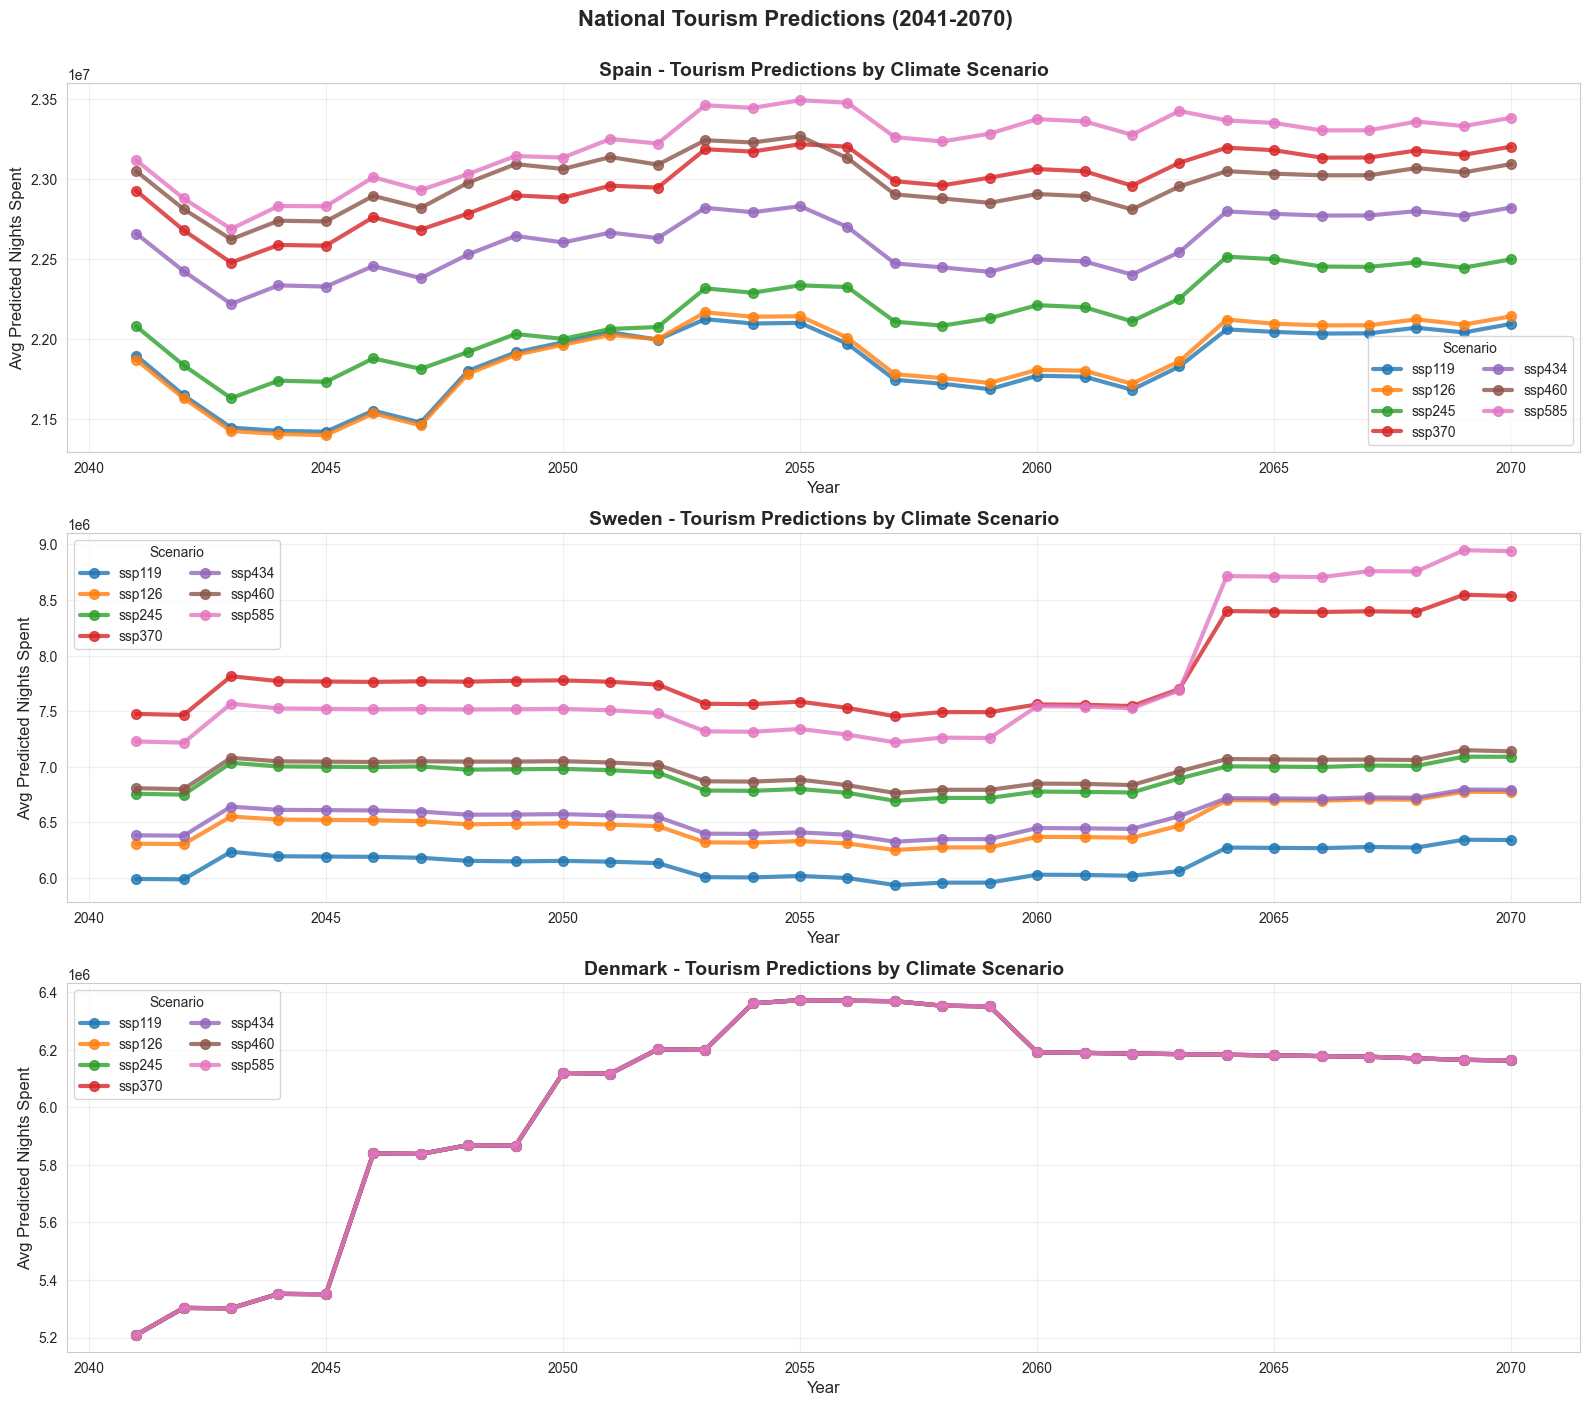

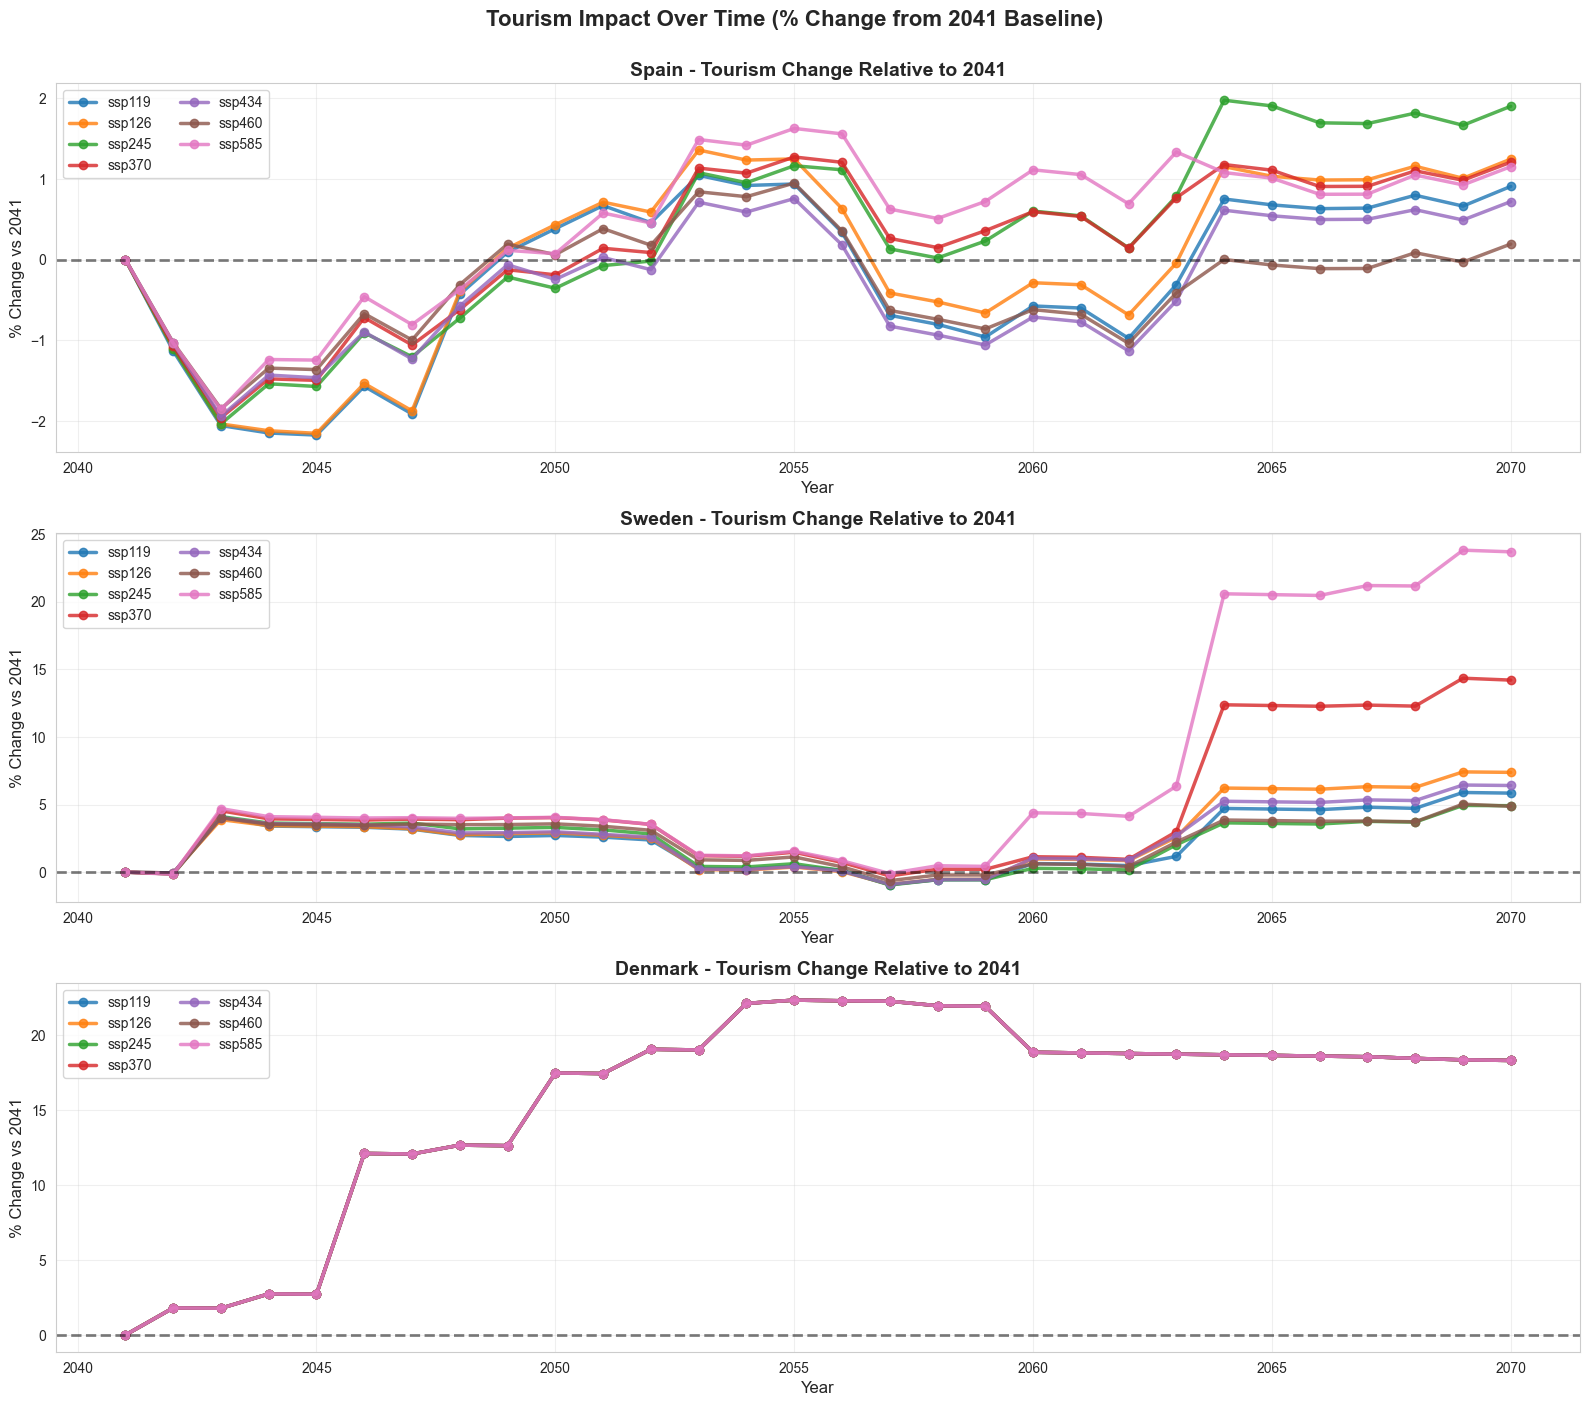

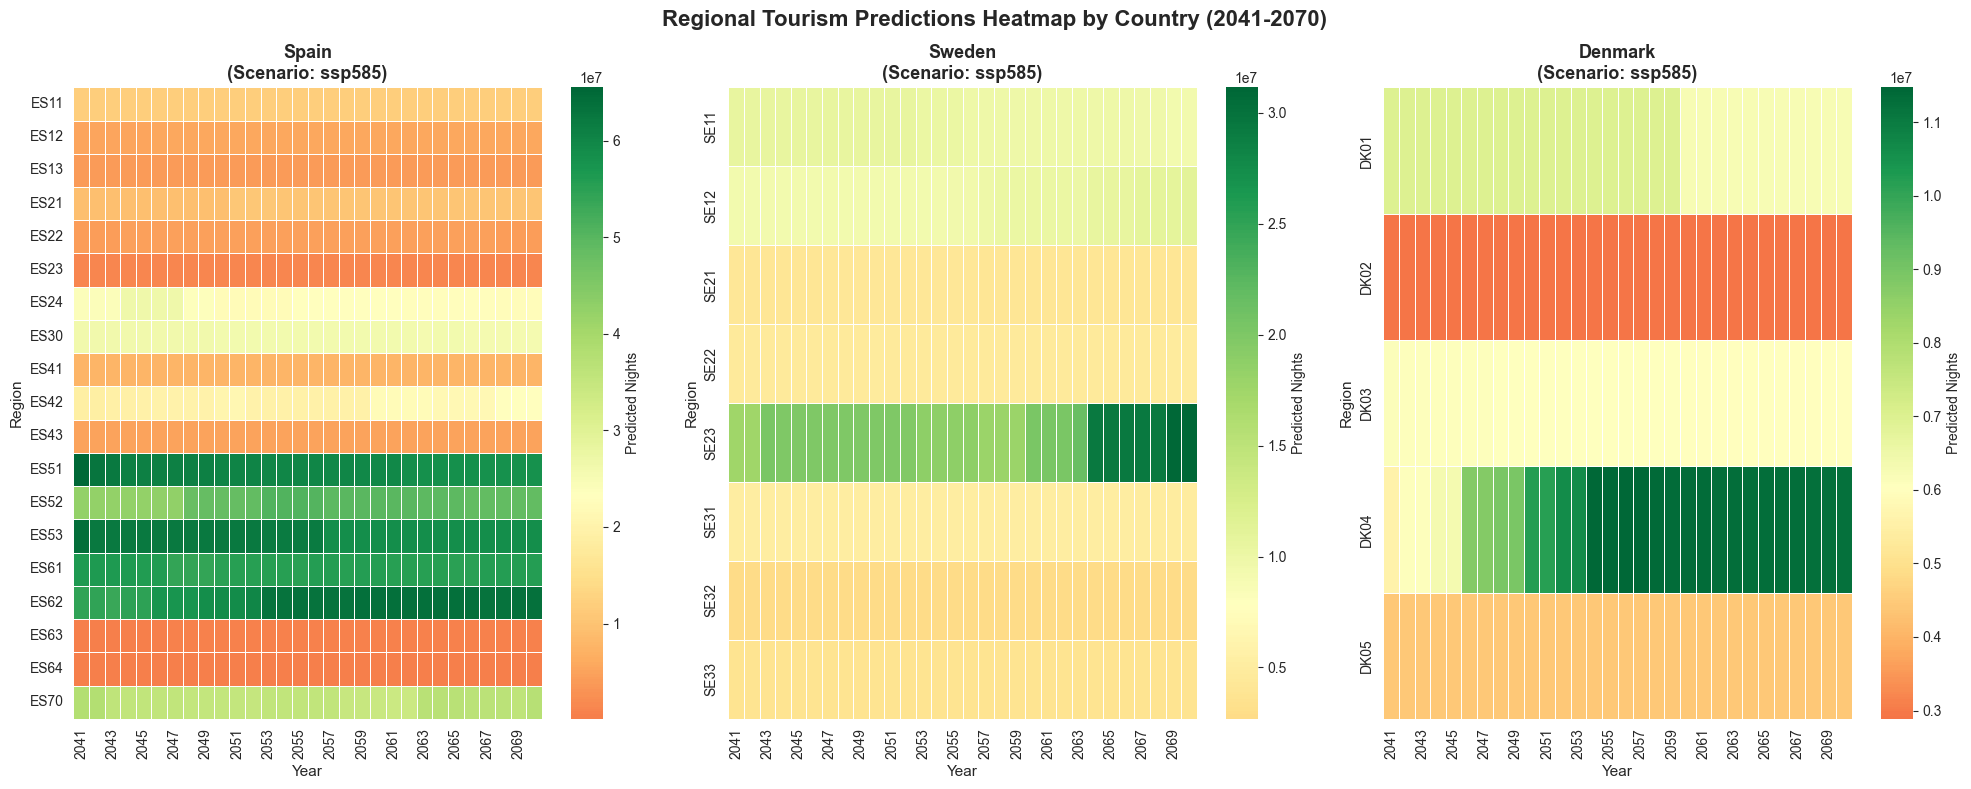

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for ES, SE, DK regions
countries = ['ES', 'SE', 'DK']
df_focus = df_prediction[df_prediction['NUTS_ID'].str.startswith(tuple(countries))]

# Set style
sns.set_style("whitegrid")

# ============================================================================
# 1. NATIONAL TOURISM PREDICTIONS (2041-2070)
# ============================================================================
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

country_names = {'ES': 'Spain', 'SE': 'Sweden', 'DK': 'Denmark'}

for idx, country in enumerate(countries):
    df_country = df_focus[df_focus['NUTS_ID'].str.startswith(country)]
    avg_by_scenario = df_country.groupby(['scenario', 'years'])['pred_stacking'].mean().reset_index()

    for scenario in avg_by_scenario['scenario'].unique():
        df_scenario = avg_by_scenario[avg_by_scenario['scenario'] == scenario]
        axes[idx].plot(df_scenario['years'], df_scenario['pred_stacking'],
                      marker='o', label=scenario, alpha=0.8, linewidth=3, markersize=7)

    axes[idx].set_xlabel('Year', fontsize=12)
    axes[idx].set_ylabel('Avg Predicted Nights Spent', fontsize=12)
    axes[idx].set_title(f'{country_names[country]} - Tourism Predictions by Climate Scenario',
                       fontsize=14, fontweight='bold')
    axes[idx].legend(fontsize=10, title='Scenario', ncol=2)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('National Tourism Predictions (2041-2070)', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# ============================================================================
# 2. TOURISM IMPACT OVER TIME (% CHANGE FROM 2041 BASELINE)
# ============================================================================
baseline_year = 2041
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

for idx, country in enumerate(countries):
    df_country = df_focus[df_focus['NUTS_ID'].str.startswith(country)]

    for scenario in df_country['scenario'].unique():
        df_scenario = df_country[df_country['scenario'] == scenario]
        avg_by_year = df_scenario.groupby('years')['pred_stacking'].mean().reset_index()

        if len(avg_by_year) > 0 and baseline_year in avg_by_year['years'].values:
            baseline_value = avg_by_year[avg_by_year['years'] == baseline_year]['pred_stacking'].values[0]
            avg_by_year['pct_change'] = ((avg_by_year['pred_stacking'] - baseline_value) / baseline_value) * 100

            axes[idx].plot(avg_by_year['years'], avg_by_year['pct_change'],
                          marker='o', label=scenario, alpha=0.8, linewidth=2.5)

    axes[idx].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=2)
    axes[idx].set_xlabel('Year', fontsize=12)
    axes[idx].set_ylabel('% Change vs 2041', fontsize=12)
    axes[idx].set_title(f'{country_names[country]} - Tourism Change Relative to 2041',
                       fontsize=14, fontweight='bold')
    axes[idx].legend(fontsize=10, ncol=2)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Tourism Impact Over Time (% Change from 2041 Baseline)',
             fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# ============================================================================
# 3. REGIONAL TOURISM PREDICTIONS HEATMAP BY COUNTRY (2041-2070)
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
scenario_selected = 'ssp585'

for idx, country in enumerate(countries):
    df_country = df_focus[(df_focus['NUTS_ID'].str.startswith(country)) &
                          (df_focus['scenario'] == scenario_selected)]

    pivot = df_country.pivot_table(values='pred_stacking',
                                    index='NUTS_ID',
                                    columns='years')

    if len(pivot) > 0:
        sns.heatmap(pivot, cmap='RdYlGn', center=pivot.mean().mean(),
                   cbar_kws={'label': 'Predicted Nights'},
                   linewidths=0.5, linecolor='white', ax=axes[idx])

        axes[idx].set_title(f'{country_names[country]}\n(Scenario: {scenario_selected})',
                           fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('Year', fontsize=11)
        axes[idx].set_ylabel('Region', fontsize=11)

plt.suptitle('Regional Tourism Predictions Heatmap by Country (2041-2070)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


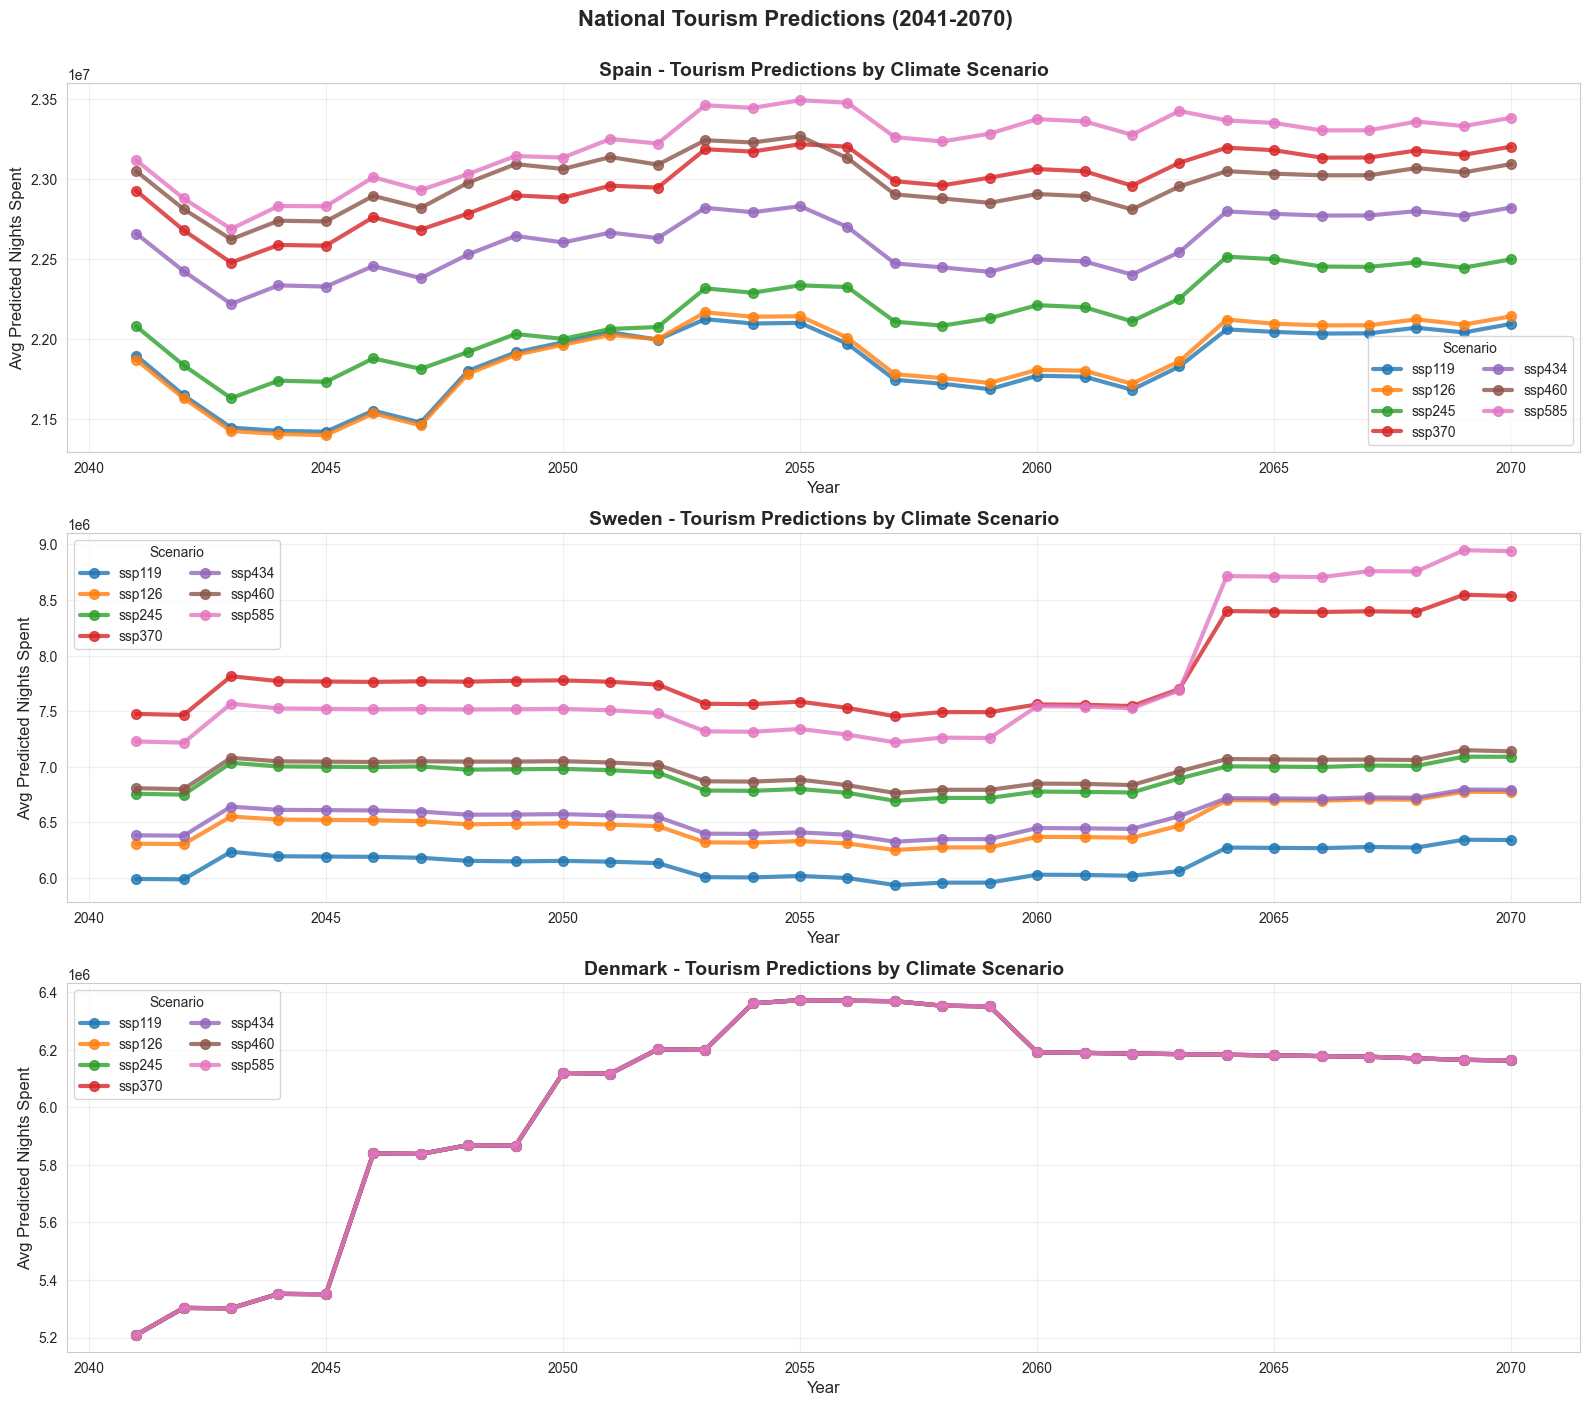

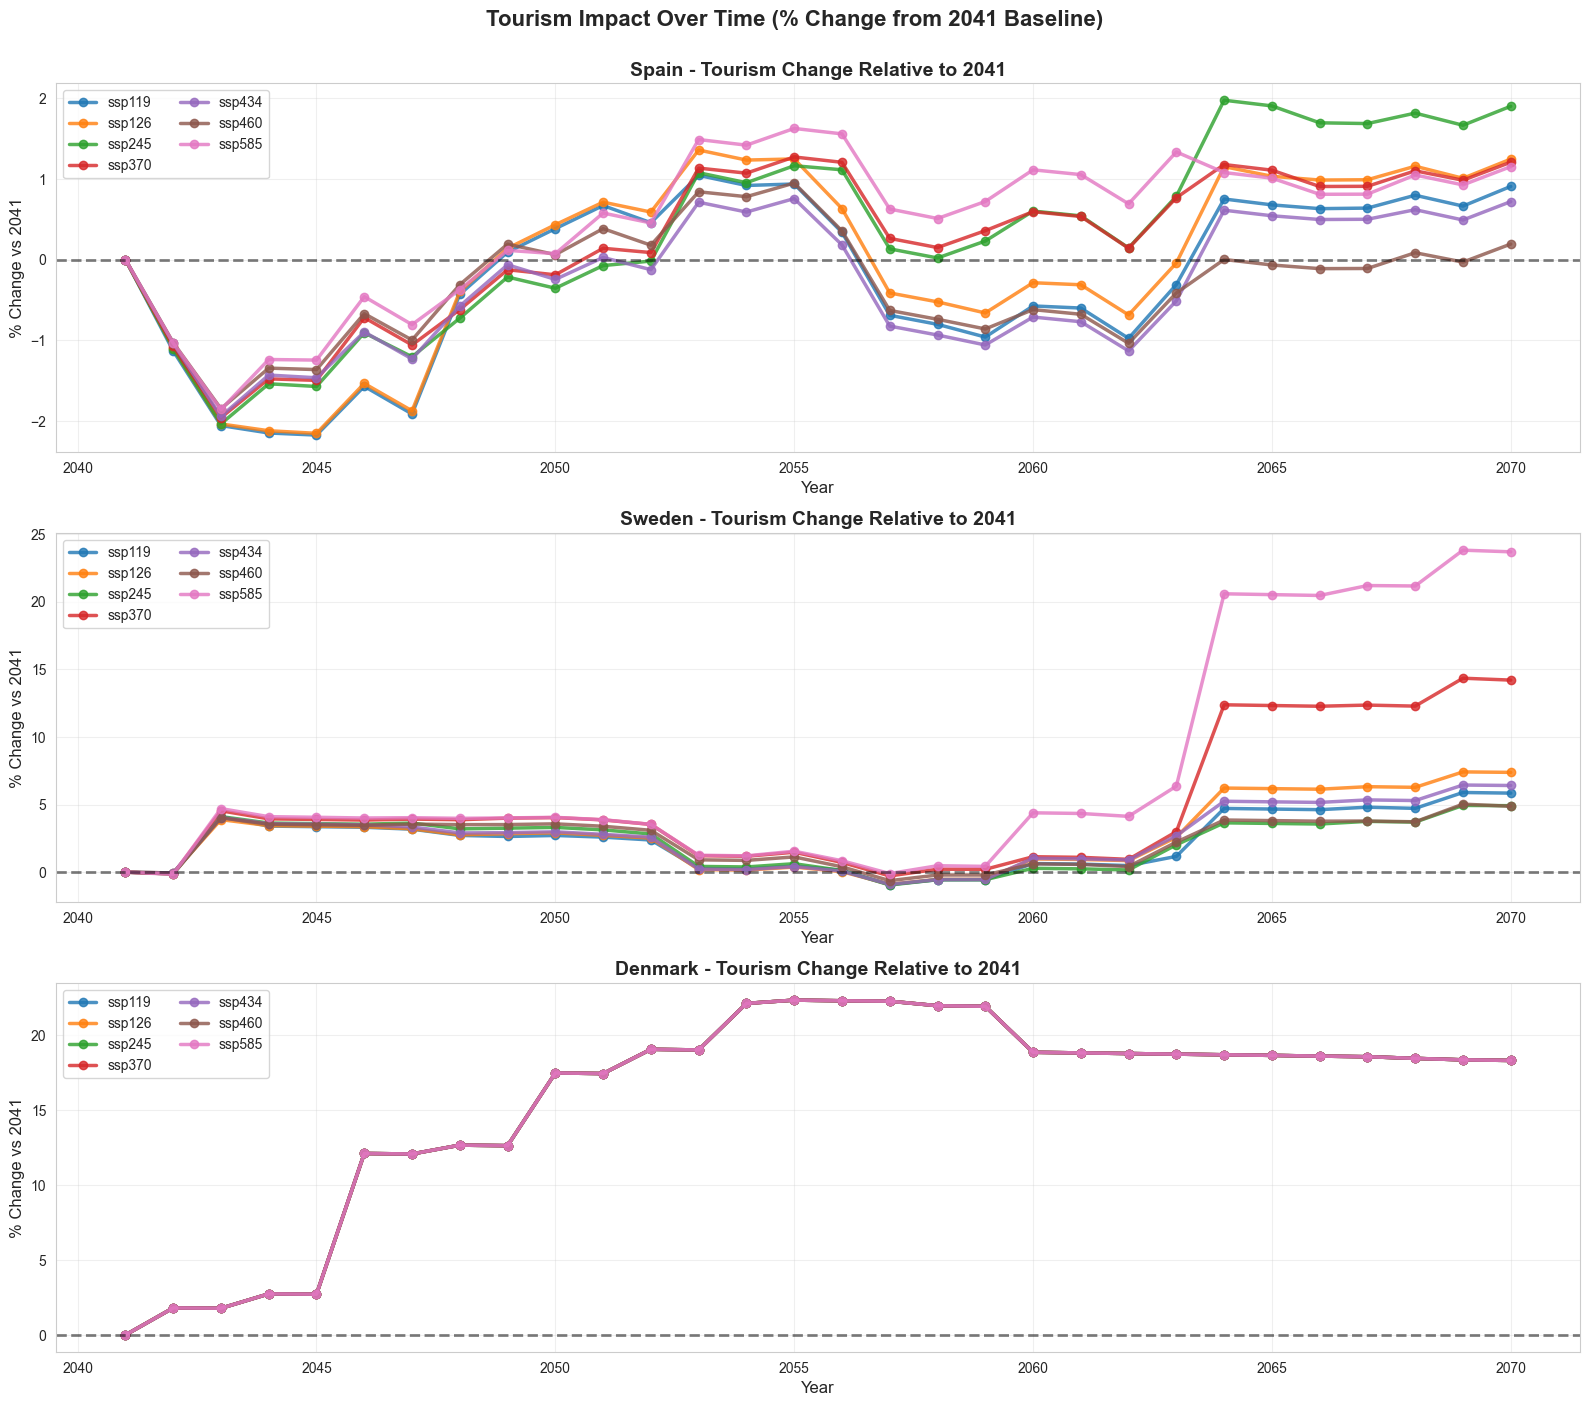

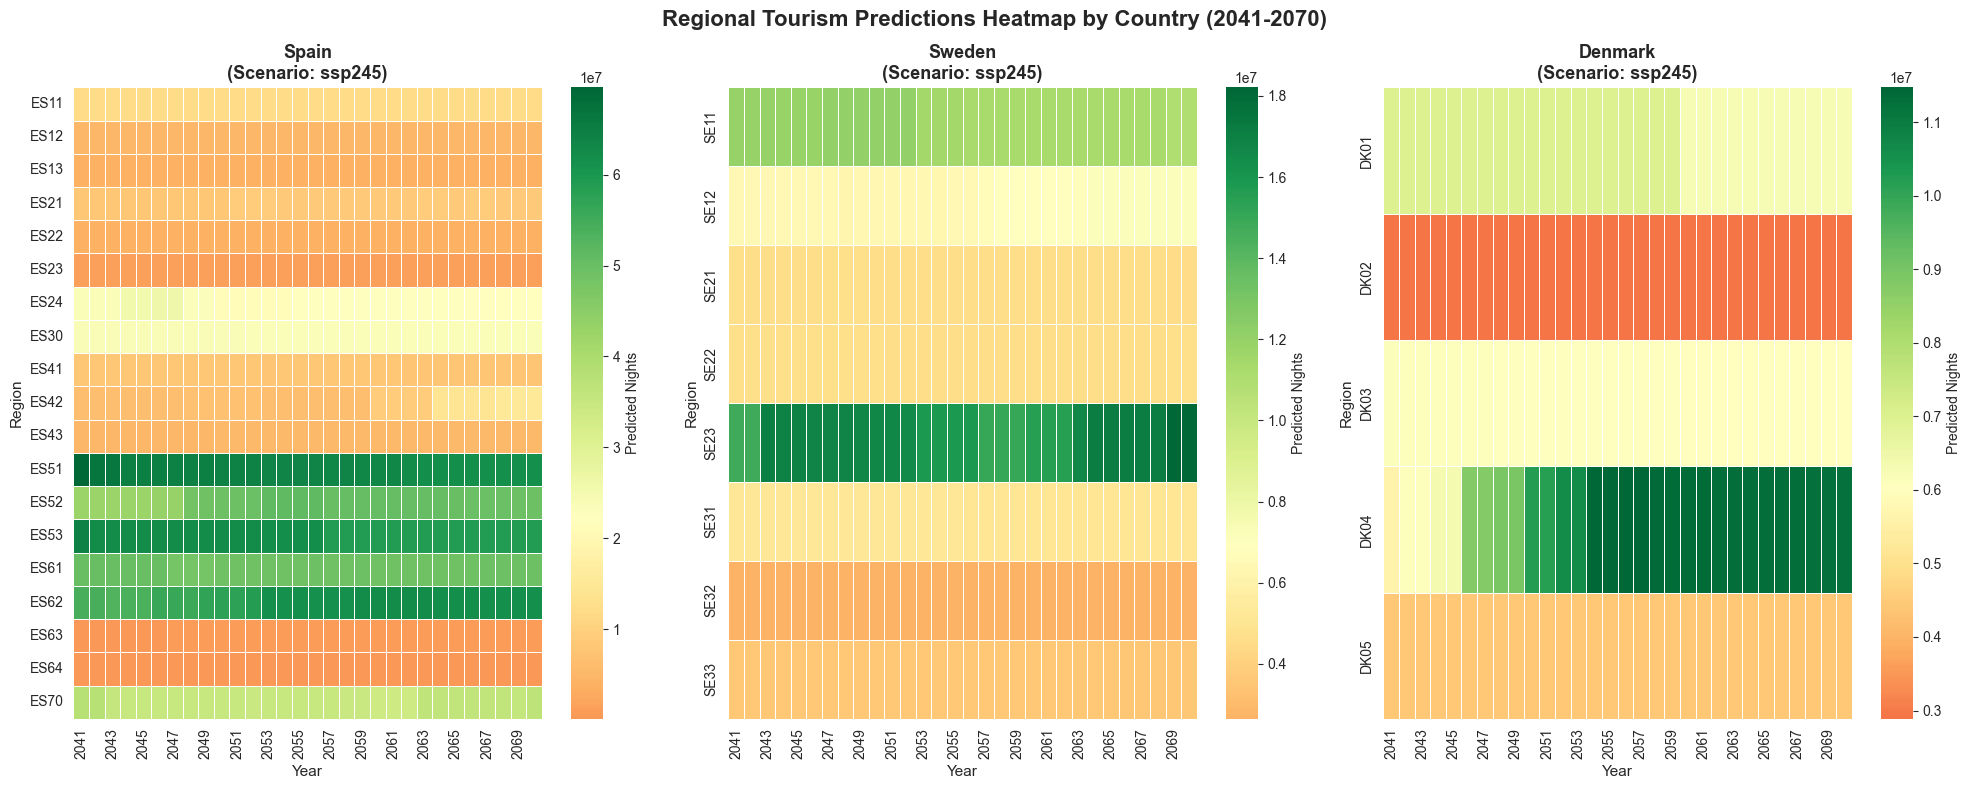

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for ES, SE, DK regions
countries = ['ES', 'SE', 'DK']
df_focus = df_prediction[df_prediction['NUTS_ID'].str.startswith(tuple(countries))]

# Set style
sns.set_style("whitegrid")

# ============================================================================
# 1. NATIONAL TOURISM PREDICTIONS (2041-2070)
# ============================================================================
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

country_names = {'ES': 'Spain', 'SE': 'Sweden', 'DK': 'Denmark'}

for idx, country in enumerate(countries):
    df_country = df_focus[df_focus['NUTS_ID'].str.startswith(country)]
    avg_by_scenario = df_country.groupby(['scenario', 'years'])['pred_stacking'].mean().reset_index()

    for scenario in avg_by_scenario['scenario'].unique():
        df_scenario = avg_by_scenario[avg_by_scenario['scenario'] == scenario]
        axes[idx].plot(df_scenario['years'], df_scenario['pred_stacking'],
                      marker='o', label=scenario, alpha=0.8, linewidth=3, markersize=7)

    axes[idx].set_xlabel('Year', fontsize=12)
    axes[idx].set_ylabel('Avg Predicted Nights Spent', fontsize=12)
    axes[idx].set_title(f'{country_names[country]} - Tourism Predictions by Climate Scenario',
                       fontsize=14, fontweight='bold')
    axes[idx].legend(fontsize=10, title='Scenario', ncol=2)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('National Tourism Predictions (2041-2070)', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# ============================================================================
# 2. TOURISM IMPACT OVER TIME (% CHANGE FROM 2041 BASELINE)
# ============================================================================
baseline_year = 2041
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

for idx, country in enumerate(countries):
    df_country = df_focus[df_focus['NUTS_ID'].str.startswith(country)]

    for scenario in sorted(df_country['scenario'].unique()):
        df_scenario = df_country[df_country['scenario'] == scenario]
        avg_by_year = df_scenario.groupby('years')['pred_stacking'].mean().reset_index()

        if len(avg_by_year) > 0:
            # Verificar si existe el baseline year
            if baseline_year in avg_by_year['years'].values:
                baseline_value = avg_by_year[avg_by_year['years'] == baseline_year]['pred_stacking'].values[0]
            else:
                # Si no existe 2041, usar el primer año disponible
                baseline_value = avg_by_year.iloc[0]['pred_stacking']
                first_year = avg_by_year.iloc[0]['years']
                print(f"⚠️  {country} - {scenario}: No baseline {baseline_year}, usando {first_year}")

            # Calcular cambio porcentual solo si baseline_value es válido
            if baseline_value > 0:
                avg_by_year['pct_change'] = ((avg_by_year['pred_stacking'] - baseline_value) / baseline_value) * 100

                # Plotear
                axes[idx].plot(avg_by_year['years'], avg_by_year['pct_change'],
                              marker='o', label=scenario, alpha=0.8, linewidth=2.5, markersize=6)
            else:
                print(f"❌ {country} - {scenario}: baseline_value inválido ({baseline_value})")

    axes[idx].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=2)
    axes[idx].set_xlabel('Year', fontsize=12)
    axes[idx].set_ylabel('% Change vs 2041', fontsize=12)
    axes[idx].set_title(f'{country_names[country]} - Tourism Change Relative to 2041',
                       fontsize=14, fontweight='bold')
    axes[idx].legend(fontsize=10, ncol=2, loc='best')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Tourism Impact Over Time (% Change from 2041 Baseline)',
             fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# ============================================================================
# 3. REGIONAL TOURISM PREDICTIONS HEATMAP BY COUNTRY (2041-2070)
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
scenario_selected = 'ssp245'

for idx, country in enumerate(countries):
    df_country = df_focus[(df_focus['NUTS_ID'].str.startswith(country)) &
                          (df_focus['scenario'] == scenario_selected)]

    pivot = df_country.pivot_table(values='pred_stacking',
                                    index='NUTS_ID',
                                    columns='years')

    if len(pivot) > 0:
        sns.heatmap(pivot, cmap='RdYlGn', center=pivot.mean().mean(),
                   cbar_kws={'label': 'Predicted Nights'},
                   linewidths=0.5, linecolor='white', ax=axes[idx])

        axes[idx].set_title(f'{country_names[country]}\n(Scenario: {scenario_selected})',
                           fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('Year', fontsize=11)
        axes[idx].set_ylabel('Region', fontsize=11)

plt.suptitle('Regional Tourism Predictions Heatmap by Country (2041-2070)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()